### Statistical Study to BOVA/WINFUT Strategy (D1/M5) only using future WINFUT
__Name__: Trading IBOV Future using BOVA11 ETF relationship (using technical data)  
__Funny name:__ The wired couple can walking apart?  
__Assets used:__ BOVA11 (EFT), WINFUT (Future of IBOV index)  
__Timeframe:__ (Technical) D1  
__Market__: Brazilian Market  
__Description:__  This strategy consist of calculate the z-score of difference between returns of price, once with have reach some level we trigger a trade, I already make some researchs on trading both instruments, but in this work I will pretend study only trading the future based on this relationship.  
You may woundery why there will be any relationship between this two assets? 
Future is a asset based in three components: (Spot Price) + (Interest Rate) + (Expectation of Players), At expired day (last hour) of future contract it should have same price of spot (IBOV index), but here in brazilian market you can't trade this index directly, but it's possible to trade trough the BOVA11 etf, so thats why I using this two assets to make a prediction.

__Goals of study__: 
Build a data base using 5 minutes bar and calculate z-score using D1, like original strategy and then take a trade in the future.

__Provider of Data__: CSV of Metatrader 5 platform (Exchange XP Investimentos)

__Initial Questions__:  
The return of original strategy is only based on future return or the strategy just work trading both assets togheter
O retorno da abertura é que é o retorno da estratégia?  

__Question raised during research process__:  
Because, etf closing his session trading before than future, it's possible to calculate a signal right there on close of etf, and make a trade future until the end of his session.
There are like a 30 minutes of trading in future without etf been trading.


__Answers at 14/05/2020 by Janderson FFerreira__:
(Still working on in this research)

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid
# import specifics functions for this work
import bova_win_backtest
from bova_win_backtest import *

# avoid boring warings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
#import importlib
#importlib.reload(bova_win_backtest)

### Loading dataframes (Bar M5)  
I just save this csv with compression xz to make file smaller.

In [15]:
path = "data"
df_bova = pd.read_csv("{}/{}".format(path, "bova_m5.xz"), compression="xz")
df_win = pd.read_csv("{}/{}".format(path, "winfut_m5.xz"), compression="xz")


### Create a new timeframe, merging two close prices by Time

* Suffix _fut means - Future 
* Suffix _eft means - BOVA11 ETF

In [32]:
bova_win_df = build_dataframe(df_win=df_win, df_bova=df_bova)
bova_win_df.tail(2)

,time,open_lower_fut,close_lower_fut,open_fut,close_fut,start_bar_sign_fut,end_bar_sign_fut,open_lower_etf,close_lower_etf,open_etf,close_etf,start_bar_sign_etf,end_bar_sign_etf
133233,2020-05-12 17:45:00,77640.0,77815.0,79550.0,77815.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN
133234,2020-05-12 17:50:00,77815.0,77600.0,79550.0,77600.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate Signals
* If z-score greater then entry signal became  equal to 1
* If z-score lower then entry signalbecame  equal to -1

some parameters are avaliable to calculate_functions:
* allow_sell: Allow sell signals (Default: True)
* allow_buy: Allow buy signals (Default: True)

___Obs: all this functions is inside of bova_win_backtest.py file___

In [38]:
bova_win_df = calculate_signals(bova_win_df, entry=1, period=20)

### Comparing with original estrategy to see if results are similars

In [23]:
def filter_by_date(dataframe):
    startdate = pd.to_datetime("2018-01-01")
    enddate = pd.to_datetime("2020-01-01")
    return dataframe.query("time >= @startdate & time < @enddate")
df_d1 = pd.read_csv("signals_d1.csv")
df_d1["time"] = pd.to_datetime(df_d1.time)

columns = ["time", "open_A", "close_A", "open_B", "close_B"]
filter_by_date(df_d1)[columns]

,time,open_A,close_A,open_B,close_B
8,2018-02-05,80.59,79.20,83770.0,81450.0
9,2018-02-06,77.62,81.15,81450.0,84340.0
10,2019-02-13,93.03,92.60,97295.0,96895.0
11,2019-12-18,108.35,110.16,113355.0,114980.0


In [24]:
columns = ["time", "open_etf", "close_etf", "open_fut", "close_fut"]
#pd.to_datetime(df_d1.time)
filter_by_date(bova_win_df)[
    (np.isin(bova_win_df.time.dt.date.astype(np.datetime64), df_d1.time.values)) &
    (bova_win_df.signal != np.inf)
][columns]

,time,open_etf,close_etf,open_fut,close_fut
73127,2018-02-05 18:05:00,80.59,79.20,83770.0,81450.0
73237,2018-02-06 18:05:00,77.62,81.15,81450.0,84340.0
100199,2019-02-13 18:05:00,93.03,92.60,97295.0,96895.0
122973,2019-12-18 18:05:00,108.35,110.16,113355.0,114980.0


### Calculate returns of backtest
Instead of just calculating using normal return, I'm using open-close because we are supouse to just buy/sell at open and close at end of day
* Signal == 1 --> __Sell B (Future)__
* Signal == -1 --> __Buy B (Future)__

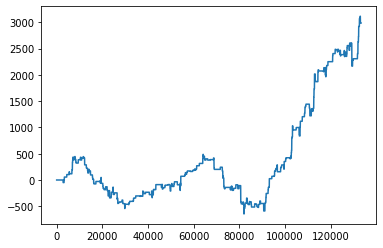

In [43]:
bova_win_df = calculate_pnl(bova_win_df)
bova_win_df.cum_profit.plot();

### Calculate some statistics

In [40]:
pd.DataFrame([get_stats(bova_win_df)]).T

,0
final_pnl,2984.000000
cum_profit,2984.000000
total_trade,298.000000
win_ratio,0.567114
profit_by_trade,10.013423
sharpe_ratio,0.094283
sortino_ratio,0.094283
loss_means,-59.303279
win_means,60.467456
total_trades,298.000000


### Get a result for a single test

In [26]:
opt_df = build_dataframe(df_win, df_bova)
opt_df = calculate_signals(opt_df, entry=2, period=30)
opt_df = calculate_pnl(opt_df)
stats = get_stats(opt_df)
pd.DataFrame([stats])

,final_pnl,cum_profit,total_trade,win_ratio,profit_by_trade,sharpe_ratio,sortino_ratio,loss_means,win_means,total_trades
0,1705.0,1705.0,69,0.681159,24.710145,0.116896,0.116896,-56.35,60.255319,69


### Its possible to get a single sample

Get a event inside dataframe, and plot some bar after and before (index should be a integer sequence)

In [22]:
columns = [
    "time", "open_fut", "close_fut", "open_etf", 
    "close_etf", "end_bar_sign_fut", "end_bar_sign_etf", "signal", 
    "signal_carry", "start_trade", "end_trade", 
    "entry_price", "fut_points", "fut_profit"
]
get_a_sample(df, "entry_price==0 & end_trade==True", plus=5, start_of=0, minus=5)[columns]

,time,open_fut,close_fut,open_etf,close_etf,end_bar_sign_fut,end_bar_sign_etf,signal,signal_carry,start_trade,end_trade,entry_price,fut_points,fut_profit
123076,2019-12-19 17:30:00,114755.0,115550.0,109.98,110.62,False,False,inf,-1.0,False,False,0.0,0.0,0.0
123077,2019-12-19 17:35:00,114755.0,115585.0,109.98,110.61,False,False,inf,-1.0,False,False,0.0,0.0,0.0
123078,2019-12-19 17:40:00,114755.0,115615.0,109.98,110.65,False,False,inf,-1.0,False,False,0.0,0.0,0.0
123079,2019-12-19 17:45:00,114755.0,115615.0,109.98,110.60,False,False,inf,-1.0,False,False,0.0,0.0,0.0
123080,2019-12-19 17:50:00,114755.0,115665.0,109.98,110.82,False,False,inf,-1.0,False,False,0.0,0.0,0.0
123081,2019-12-19 17:55:00,114755.0,115710.0,109.98,110.82,False,NaN,inf,-1.0,False,False,0.0,0.0,0.0
123082,2019-12-19 18:00:00,114755.0,115740.0,109.98,110.82,False,NaN,inf,-1.0,False,False,0.0,0.0,0.0
123083,2019-12-19 18:05:00,114755.0,115785.0,109.98,110.82,True,NaN,inf,-1.0,False,False,0.0,0.0,0.0
123084,2019-12-20 09:00:00,115630.0,115630.0,109.98,110.82,False,NaN,inf,-1.0,False,False,0.0,0.0,0.0
123085,2019-12-20 09:05:00,115630.0,115935.0,109.98,110.82,False,NaN,inf,-1.0,False,False,0.0,0.0,0.0


### Optmization

Function used is optimization_process, in this process we will iterate over all posibilities (brute force) to make a list with results

In [ ]:
import itertools
periods = list(range(10, 20, 10))
entries = [0.05, 0.10, 0.15, 0.25, 0.3, 0.50, 1]
importlib.reload(bova_win_backtest)
result = bova_win_backtest.optimization_process(df_win, df_bova, list(itertools.product(periods, entries)))

In [59]:
results_df = pd.DataFrame.from_dict(result, orient="index")

In [60]:
results_df.sort_values(["win_ratio"], ascending=False)

,p_entry,p_period,final_pnl,cum_profit,total_trade,win_ratio,profit_by_trade,sharpe_ratio,sortino_ratio,loss_means,win_means
10_1,1.00,10,2112.0,2112.0,167,0.598802,12.646707,0.093672,0.093672,-57.412698,57.290000
10_0.5,0.50,10,4498.0,4498.0,355,0.591549,12.670423,0.129491,0.129491,-58.482014,60.128571
10_0.3,0.30,10,5050.0,5050.0,451,0.583149,11.197339,0.134288,0.134288,-56.011050,57.749049
10_0.15,0.15,10,5335.0,5335.0,534,0.576779,9.990637,0.134163,0.134163,-54.575342,56.126623
10_0.25,0.25,10,4756.0,4756.0,481,0.571726,9.887734,0.124062,0.124062,-55.025126,57.112727
10_0.1,0.10,10,5306.0,5306.0,563,0.570160,9.424512,0.130640,0.130640,-54.276596,56.264798
10_0.05,0.05,10,5892.0,5892.0,600,0.570000,9.820000,0.143620,0.143620,-52.031873,55.415205


### Choosing the best cumulative profit

In [ ]:
objective_function = "cum_profit"
r = results_df.pivot("p_period", "p_entry", objective_function)
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(r, annot=True, fmt=".4f", cmap="YlGnBu")
results_df.sort_values([objective_function], ascending=False).head(5)

### Choosing Best Cumulative Profit adding Transaction Costs

In [ ]:
objective_function = "final_pnl"
r = results_df.pivot("p_period", "p_entry", objective_function)
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(r, annot=True, fmt=".4f", cmap="YlGnBu")
results_df.sort_values([objective_function], ascending=False).head(5)

### Chosing the best Win Ratio

In [ ]:
objective_function = "win_ratio"
r = results_df.pivot("p_period", "p_entry", objective_function)
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(r, annot=True, fmt=".4f", cmap="YlGnBu")
results_df.sort_values([objective_function], ascending=False).head(5)

### Choosing by Sharpe Ratio

In [ ]:
objective_function = "sharpe_ratio"
r = results_df.pivot("p_period","p_entry", objective_function)
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(r, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=.5)
results_df.sort_values([objective_function], ascending=False).head(5)

In [29]:
import itertools
results = {}
periods = list(range(10, 200, 10))
entries = [0.05, 0.10, 0.15, 0.25, 0.3, 0.50, 1]
count=0
all_items = list(itertools.product(periods, entries))
for period, entry in all_items:
    opt_df = build_dataframe(df_win, df_bova)
    opt_df = calculate_signals(opt_df, entry=entry, period=period, allow_buy=False)
    opt_df = calculate_pnl(opt_df)
    stats = get_stats(opt_df)
    final_pnl = stats["final_pnl"]
    results["{}_{}".format(period, entry)] = {
        "p_entry": entry,
        "p_period": period,
        "final_pnl": stats["final_pnl"],
        "cum_profit": stats["cum_profit"],
        "total_trade": stats["total_trades"],
        "win_ratio": stats["win_ratio"],
        "profit_by_trade": stats["profit_by_trade"],
        "sharpe_ratio": stats["sharpe_ratio"],
        "sortino_ratio": stats["sortino_ratio"],
        "loss_means": stats["loss_means"],
        "win_means": stats["win_means"]
    }
    if (count % 12)==0:
        print("{} of {}\r".format(count, len(all_items)))
    count+=1
    results_df_sell = pd.DataFrame.from_dict(results, orient="index")


NameError: name 'calc_carry_signal' is not defined

In [ ]:
results_df_sell.sort_values(["final_pnl"], ascending=False)

### Get Only Bars when Future is Open

In [9]:
df_win["time"] = pd.to_datetime(df_win.time)
df_bova["time"] = pd.to_datetime(df_bova.time)
#pd.Series(list(set(df_win.time.values) - set(df_bova.time.values))).value_counts()
